
# 🩺 Proyecto Minimal: Neumonía en Radiografías de Tórax (Colab)
**Objetivo:** Entrenar un clasificador binario (NORMAL vs PNEUMONIA) con **EfficientNetB0** usando Google Colab, reportar métricas clave y dejar el código listo para subir a GitHub.

> Uso académico. No es un sistema de diagnóstico médico.



## 1) Setup rápido
Instala y verifica dependencias mínimas.


In [1]:

!pip -q install kaggle opencv-python-headless

import os, numpy as np, tensorflow as tf, matplotlib.pyplot as plt, random
SEED = 123; random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
IMG_SIZE=(224,224); BATCH=32

print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


TF: 2.19.0
GPU: []



## 2) Dataset (Kaggle)
Sube tu `kaggle.json` (Kaggle → Profile → Account → *Create New API Token*). Se descarga **Chest X-Ray Images (Pneumonia)**.


In [3]:

from google.colab import files, userdata
import pathlib

print("Sube tu kaggle.json")
uploaded = files.upload()
pathlib.Path("/root/.kaggle").mkdir(parents=True, exist_ok=True)
with open("/root/.kaggle/kaggle.json","wb") as f: f.write(uploaded["kaggle.json"])
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content -q
!unzip -q /content/chest-xray-pneumonia.zip -d /content
DATA_DIR="/content/chest_xray"
print("OK. Carpetas:", os.listdir(DATA_DIR))


Sube tu kaggle.json


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
OK. Carpetas: ['chest_xray', 'val', 'train', '__MACOSX', 'test']



## 3) Carga de datos y aumentación
Usamos `tf.data` y un pipeline simple con aumentación ligera.


In [4]:

from tensorflow.keras.preprocessing import image_dataset_from_directory as ds_from_dir

train_ds = ds_from_dir(f"{DATA_DIR}/train", label_mode="binary", image_size=IMG_SIZE, batch_size=BATCH, seed=SEED)
val_ds   = ds_from_dir(f"{DATA_DIR}/val",   label_mode="binary", image_size=IMG_SIZE, batch_size=BATCH, seed=SEED)
test_ds  = ds_from_dir(f"{DATA_DIR}/test",  label_mode="binary", image_size=IMG_SIZE, batch_size=BATCH, shuffle=False)

AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.shuffle(1024,seed=SEED).prefetch(AUTOTUNE)
val_ds=val_ds.prefetch(AUTOTUNE); test_ds=test_ds.prefetch(AUTOTUNE)

data_aug=tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.05),
  tf.keras.layers.RandomZoom(0.05),
])
CLASSES=["NORMAL","PNEUMONIA"]


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.



## 4) Modelo (EfficientNetB0) + Entrenamiento breve
Primero congelamos la base; luego un pequeño *fine-tuning*.


In [5]:

from tensorflow.keras import layers, models

base=tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,))
base.trainable=False

inp=layers.Input(IMG_SIZE+(3,))
x=tf.keras.applications.efficientnet.preprocess_input(inp)
x=data_aug(x); x=base(x, training=False)
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dropout(0.25)(x)
out=layers.Dense(1, activation="sigmoid")(x)
model=models.Model(inp,out)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])

es=tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss")
ck=tf.keras.callbacks.ModelCheckpoint("best.keras", save_best_only=True, monitor="val_loss")

history=model.fit(train_ds, validation_data=val_ds, epochs=6, callbacks=[es,ck], verbose=1)

# Fine-tuning corto
base.trainable=True
for L in base.layers[:-20]: L.trainable=False
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])
history_ft=model.fit(train_ds, validation_data=val_ds, epochs=6, callbacks=[es,ck], verbose=1)

best=tf.keras.models.load_model("best.keras")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 470s 3s/step - accuracy: 0.8185 - loss: 0.4028 - val_accuracy: 0.8750 - val_loss: 0.4531
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 459s 3s/step - accuracy: 0.9098 - loss: 0.2152 - val_accuracy: 0.8750 - val_loss: 0.4179
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 459s 3s/step - accuracy: 0.9241 - loss: 0.1930 - val_accuracy: 0.8750 - val_loss: 0.3047
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 454s 3s/step - accuracy: 0.9370 - loss: 0.1601 - val_accuracy: 0.9375 - val_loss: 0.1994
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 494s 3s/step - accuracy: 0.9385 - loss: 0.1566 - val_accuracy: 0.8750 - val_loss: 0.2113
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 452s 3s/step - accuracy: 0.9530 - loss: 0.1322 - val_accuracy: 0.8750 - val_loss: 0.2561
Epoch 1/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 537s 3s/step - accuracy: 0.9231 - loss: 0.2050 - val_accuracy: 0.9375 - val_loss: 0.1978
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 547s 3s/step -


## 5) Métricas y gráficos (test)
Accuracy, Precision, Recall, F1, ROC-AUC; matriz de confusión y curva ROC.


Accuracy: 0.8510 | Precision: 0.8126 | Recall: 0.9897 | F1: 0.8925 | ROC-AUC: 0.9658

Reporte:
               precision    recall  f1-score   support

      NORMAL       0.97      0.62      0.76       234
   PNEUMONIA       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.85      0.84       624



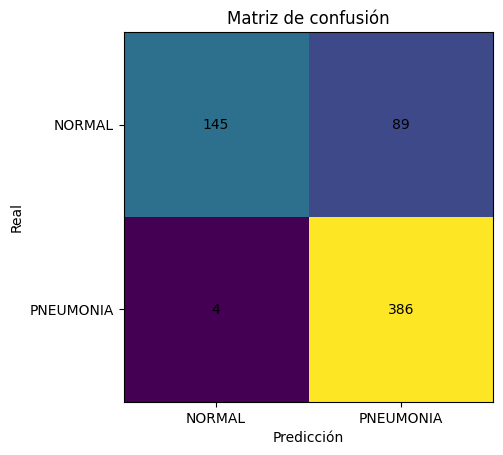

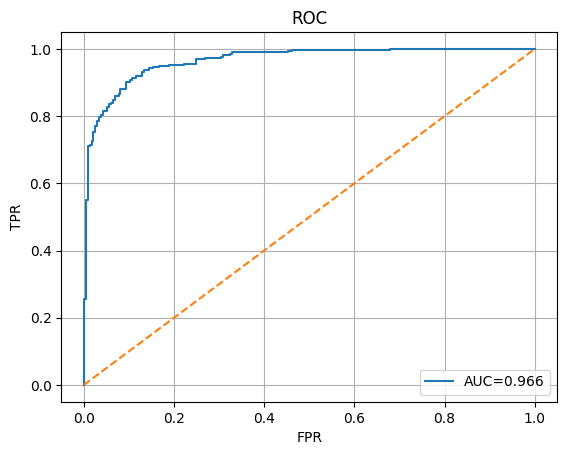

In [6]:

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support
import numpy as np, matplotlib.pyplot as plt

y_true=np.concatenate([y.numpy().astype(int).ravel() for _,y in test_ds])
y_prob=best.predict(test_ds, verbose=0).ravel()
y_pred=(y_prob>=0.5).astype(int)

acc=(y_pred==y_true).mean()
prec, rec, f1, _=precision_recall_fscore_support(y_true,y_pred,average="binary",zero_division=0)
auc=roc_auc_score(y_true,y_prob)

print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")
print("\nReporte:\n", classification_report(y_true,y_pred,target_names=CLASSES))

# Matriz de confusión
cm=confusion_matrix(y_true,y_pred)
plt.figure(); plt.imshow(cm); plt.title("Matriz de confusión")
plt.xticks([0,1],CLASSES); plt.yticks([0,1],CLASSES)
for i in range(2):
  for j in range(2):
    plt.text(j,i,cm[i,j],ha="center",va="center")
plt.xlabel("Predicción"); plt.ylabel("Real"); plt.grid(False); plt.show()

# Curva ROC
fpr,tpr,_=roc_curve(y_true,y_prob)
plt.figure(); plt.plot(fpr,tpr,label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend(); plt.grid(True); plt.show()



## 6) Grad-CAM (una imagen)
Mapa de activación para interpretar la predicción.


In [7]:

import tensorflow as tf, numpy as np, cv2, matplotlib.pyplot as plt

# Ubicar capa conv final dentro de la base
def find_last_conv(model_base):
  for L in reversed(model_base.layers):
    if isinstance(L, tf.keras.layers.Conv2D): return L.name
  return None

base_layer = best.layers[2].name  # submodelo EfficientNet
last_conv = find_last_conv(best.get_layer(base_layer))

def gradcam(img_array, model, base_name, last_conv_name):
  base = model.get_layer(base_name)
  last_conv_layer = base.get_layer(last_conv_name)
  gmodel=tf.keras.Model([model.inputs],[last_conv_layer.output, model.output])
  with tf.GradientTape() as tape:
    conv_out, preds = gmodel(img_array)
    loss = preds[:,0]
  grads = tape.gradient(loss, conv_out)
  pooled = tf.reduce_mean(grads, axis=(0,1,2))
  conv_out=conv_out[0]
  heat=tf.reduce_sum(tf.multiply(pooled,conv_out),axis=-1)
  heat=np.maximum(heat,0)/ (np.max(heat)+1e-8)
  return heat.numpy()

for imgs, labels in test_ds.take(1):
  img=imgs[0:1]; true=int(labels[0].numpy())

heat=gradcam(img,best,base_layer,last_conv)
img_uint8=tf.image.resize(img, (224,224)).numpy()[0].astype("uint8")
heat_res=cv2.resize((heat*255).astype("uint8"), (224,224))
heat_color=cv2.applyColorMap(heat_res, cv2.COLORMAP_JET)
superimposed=cv2.addWeighted(img_uint8,0.6,heat_color,0.4,0)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img_uint8); plt.title("Imagen"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(heat_res, cmap="jet"); plt.title("Grad-CAM"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(superimposed); plt.title("Superpuesta"); plt.axis("off")
plt.tight_layout(); plt.show()


/tmp/ipython-input-1120477770.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  img=imgs[0:1]; true=int(labels[0].numpy())
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m132809236910736\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 224, 224, 3), dtype=float32)\n  • training=None\n  • mask=None\n  • kwargs=<class 'inspect._empty'>"


## 7) Guardar artefactos
Modelo y métricas principales en archivos.


In [ ]:

import pandas as pd, numpy as np, os

best.save("/content/model_minimal.keras")
metrics=pd.DataFrame([{"accuracy":float(acc),"precision":float(prec),"recall":float(rec),"f1":float(f1),"roc_auc":float(auc)}])
metrics.to_csv("/content/metrics_minimal.csv", index=False)

print("Guardados:")
!ls -lh /content | grep -E "minimal\.keras|metrics_minimal\.csv"



## 8) (Opcional) Subir a GitHub
- Crea un **PAT** (Personal Access Token) con `contents: write`.
- Cambia `USUARIO`, `REPO` y (si aplica) `RAMA`.


In [ ]:

# Descomenta para usar (opcional)
# !git config --global user.name "Tu Nombre"
# !git config --global user.email "[email protected]"
# REPO_URL="https://github.com/USUARIO/REPO.git"  # <- cambia
# !git clone $REPO_URL
# %cd REPO
# # Copiar el notebook manualmente (desde Archivo → Descargar .ipynb) o ajustar ruta si ya conoces el nombre
# # !cp "/content/NombreDeTuNotebook.ipynb" .
# !cp /content/metrics_minimal.csv .
# !cp /content/model_minimal.keras .  # opcional por tamaño
# with open(".gitignore","a") as f: f.write("\nchest_xray/\n*.zip\n*.keras\n")
# import getpass, os
# os.environ["GH_TOKEN"]=getpass.getpass("Pega tu GitHub PAT (contents:write): ")
# !git remote set-url origin https://${GH_TOKEN}@github.com/USUARIO/REPO.git
# !git add . && git commit -m "Proyecto minimal: RX tórax con EfficientNetB0" && git push origin HEAD:main
